In [58]:
import os 

epochs = [20, 50, 100]

In [59]:
os.listdir('20/')

['Deconvolution_attributions.pt',
 'DeepLiftShap_attributions.pt',
 'InputXGradient_attributions.pt',
 'IG_attributions.pt',
 'Saliency_attributions.pt',
 'DeepLift_attributions.pt',
 'GuidedBackprop_attributions.pt',
 'GradientShap_attributions.pt']

In [63]:
import torch

def load_attrs(epoch):
    ig = torch.load(f'{epoch}/IG_attributions.pt')
    gs = torch.load(f'{epoch}/GradientShap_attributions.pt')
    
    dl = torch.load(f'{epoch}/DeepLift_attributions.pt')
    dls = torch.load(f'{epoch}/DeepLiftShap_attributions.pt')
    
    s = torch.load(f'{epoch}/Saliency_attributions.pt')
    ixg = torch.load(f'{epoch}/InputXGradient_attributions.pt')
    
    dc = torch.load(f'{epoch}/Deconvolution_attributions.pt')
    gbp = torch.load(f'{epoch}/GuidedBackprop_attributions.pt')

    return [ig, gs, dl, dls, dc, ixg, s, gbp]

In [64]:
import numpy as np

def process_attr(attributions):
    # C, H, W -> H, W, C
    attributions = attributions[0].permute(1,2,0).detach().cpu().numpy()

    # flattern to 1D
    attributions = np.sum(np.abs(attributions), axis=-1)

    # normalise attributions to [0,1]
    attributions -= np.min(attributions)
    attributions /= np.max(attributions)

    return attributions

In [77]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def sim_mat_show(processed_attrs):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(cosine_similarity(np.stack(processed_attrs)), cmap='Purples', vmin=0.0, vmax=1.0)
    labels = ['IG', 'GS', 'DL', 'DLS', 'DeC', 'IxG', 'Sal', 'GBp']
    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)
    ax.xaxis.set_ticks_position("top")
    fig.colorbar(im)
    plt.show()

In [101]:
average_mat = np.zeros((len(epochs), len(attrs) + 1))

for i in range(len(epochs)):
    epoch = epochs[i]
    attrs = load_attrs(epoch)
    processed_attrs = [process_attr(attr).reshape((-1)) for attr in attrs]
    sim_mat = cosine_similarity(np.stack(processed_attrs))
    average_mat[i][0] = (np.sum(sim_mat) - len(attrs))/ (len(attrs)**2 - len(attrs))
    for j in range(len(sim_mat)):
        average_mat[i][j+1] = ((np.sum(sim_mat[j]) - 1)/7)
#     sim_mat_show(processed_attrs)

In [102]:
average_mat

array([[0.6354527 , 0.59096061, 0.37025617, 0.69626352, 0.69628265,
        0.66582224, 0.71795841, 0.68778398, 0.65829403],
       [0.6181522 , 0.48209164, 0.58484132, 0.65196755, 0.66643978,
        0.64314616, 0.66454294, 0.59497661, 0.65721164],
       [0.71599365, 0.50921444, 0.76295879, 0.76040223, 0.76015682,
        0.73397808, 0.78376035, 0.72912058, 0.6883579 ]])

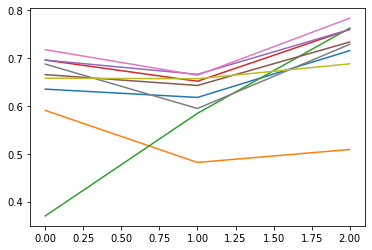

In [104]:
for i in range(len(average_mat[0])):
    plt.plot(np.arange(len(epochs)), average_mat[:,i])